In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
from matplotlib import patches
import seaborn as sns
%matplotlib notebook

In [2]:
from objective_function import *
from optimiser import *

In [489]:
class adam(optimizer):
    def __init__(self):
        self.alpha = 0.01
        self.beta_1 = 0.9
        self.beta_2 = 0.999
        self.epsilon = 1e-8
        self.max_iter = 10000
        self.tol = 1e-2
        
    def set_parameters(self, paras):
        self.x0 = paras['x0']
        self.alpha = paras['alpha']
        self.beta_1 = paras['beta_1']
        self.beta_2 = paras['beta_2']
        self.epsilon = paras['epsilon']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
        
    def optimise(self, obj):
        m_t = 0 
        v_t = 0 
        t = 0
        x = self.x0
        while t < self.max_iter:					#till it gets converged
            t+=1
            g_t = obj.dfunc(x)		#computes the gradient of the stochastic function
            m_t = self.beta_1*m_t + (1-self.beta_1)*g_t	#updates the moving averages of the gradient
            v_t = self.beta_2*v_t + (1-self.beta_2)*(g_t*g_t)	#updates the moving averages of the squared gradient
            m_cap = m_t/(1-(self.beta_1**t))		#calculates the bias-corrected estimates
            v_cap = v_t/(1-(self.beta_2**t))		#calculates the bias-corrected estimates
            x_prev = x								
            x = x - (self.alpha*m_cap)/(np.sqrt(v_cap)+self.epsilon)	#updates the parameters
            if(np.linalg.norm(x-x_prev) < 1e-5):		#checks if it is converged or not
                break
        return x, t
        

In [482]:
class line_search(adjust_optimizer):
    def __init__(self, alpha=1, beta=0.1):
        self.alpha = alpha
        self.beta = beta
        self.max_iter = 100
        self.tol = 1e-2
    def set_parameters(self, paras):
        self.x0 = None if 'x0' not in paras.keys() else paras['x0']
        self.alpha = paras['alpha']
        self.beta = paras['beta']
        self.max_iter = paras['max_iter']
        self.tol = paras['tol']
    def optimise(self, obj):
        '''
        @param x0: initial point position
        @param alpha: initial step size
        @param beta: control the armijo condition
        @return x: point position after moving to local minimum
        '''
        x = self.x0.copy().reshape(2,)
        alpha_ = self.alpha
        tao = 0.5
        fx = obj.func(x)
        p = - obj.dfunc(x)
        fnx = obj.func(x + alpha_ * p)
        eval_cnt = 4
        for k in range(self.max_iter):
            while fnx > fx + alpha_ * self.beta * (-p @ p):
                alpha_ *= tao
                fnx = obj.func(x + alpha_ * p)
                eval_cnt += 1
            x += alpha_ * p
            fx = fnx
            p = -obj.dfunc(x)
            fnx = obj.func(x + alpha_ * p)
            eval_cnt += 2
            if np.linalg.norm(p) < self.tol:
                break
        return x, eval_cnt

In [490]:
ad = adam()
x0 = np.array([69.193, 82.221])
paras = {'x0':x0, 'alpha':0.01, 'beta_1':0.9, 'beta_2':0.999, 'epsilon':1e-8, 'max_iter':100000, 'tol':1e-2}
ad.set_parameters(paras)
%time ad.optimise(ak)

CPU times: user 8.27 ms, sys: 1.29 ms, total: 9.56 ms
Wall time: 8.4 ms


(array([69.00004112, 81.99992652]), 153)

In [484]:
line = line_search()
x0 = np.array([69.193, 82.221])
paras = {'x0':x0, 'alpha':1, 'beta':0.1, 'max_iter':100, 'tol':1e-2}
line.set_parameters(paras)
%time line.optimise(ak)

CPU times: user 1.45 ms, sys: 237 µs, total: 1.69 ms
Wall time: 1.52 ms


(array([69.00011095, 82.00007568]), 41)

In [488]:
l1 = line_search_1step()
paras = {'x0':x0, 'alpha':1, 'beta':0.1, 'max_iter':100, 'tol':1e-2}
l1.set_parameters(paras)
%time l1.optimise(ak)

CPU times: user 240 µs, sys: 38 µs, total: 278 µs
Wall time: 247 µs


(array([68.95310193, 81.96908965]), 8)

In [9]:
class post_analysis_multi():
    def __init__(self, points, res):
        self.points = points
        self.res = res
        self.num = self.res.shape[0]
    def plot_prob_vs_radius(self, *args):
        def count_global_min(res, points):        
            distance = np.linalg.norm(points, axis=1)
            idx = np.argsort(distance)
            dis_ascending = distance[idx]
            res_ascending = res[idx]
            prob = np.zeros((self.num, ))
            for i in range(self.num):
                prob[i] = np.sum(res_ascending[:i+1] == 1) / (i + 1) 
            return dis_ascending, prob
        argc = len(args)
        assert argc%2 == 0
        pair_cnt = int(argc / 2)
        dis_ascendings = np.zeros((self.num, pair_cnt + 1))
        probs = np.zeros((self.num, pair_cnt + 1))
        dis_ascendings[:,0], probs[:,0] = count_global_min(self.res, self.points)
        for i in range(pair_cnt):
            dis_ascendings[:,i+1], probs[:,i+1] = count_global_min(args[i*2], args[i*2+1])
        fig = plt.figure(figsize=(8,4))
        ax = fig.add_subplot(1, 1, 1)
        ax.set_xlim(0, np.max(dis_ascendings))
        ax.set_ylim(0, 2)
        ax.set_xlabel('distance from origin', fontsize=13)
        ax.set_ylabel('prob of global minminum', fontsize=13)
        for i in range(pair_cnt+1):
            ax.plot(dis_ascendings[:,i], probs[:,i])
        plt.show()

    def plot_cloud_point(self):
        fig = plt.figure(figsize=(7,7))
        '''
        # one quadrant
        x1 = np.hstack((self.points[:,0], self.points[:,1]))
        y1 = np.hstack((self.points[:,1], self.points[:,0]))
        res1 = np.hstack((self.res, self.res))
        # two qudrant
        x2 = np.hstack((x1, -x1))
        y2 = np.hstack((y1, y1))
        res2 = np.hstack((res1, res1))
        # four qudrant
        x = np.hstack((x2, -x2))
        y = np.hstack((y2, -y2))
        hue = np.hstack((res2, res2))
        '''
        x = self.points[:,0]
        y = self.points[:,1]
        hue = self.res
        p = sns.scatterplot(x=x, y=y, color="r", hue=hue, hue_norm=(0, 1), legend=False)

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
ro = round_off()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro
paras['multi_runs'] = True
cma = cma_es()

# boil down to one expreiment
exp = single_experiment()
exp.set_objective(ak)


num = points.shape[0]
res = np.zeros((num, ))
for i in range(num):
    paras['mean0'] = points[i].reshape(2,1)
    cma.set_parameters(paras)
    exp.set_optimizer(cma)
    status = exp.do()
    if(status == 'global minimum'):
        res[i] = 1
    else:
        res[i] = 0

In [ ]:
class multiple_experiment:
    def __init__(self):
        self.single_exp = single_experiment()
    def set_objective(self, objective_func):
        self.single_exp.set_objective(objective_func)
    def set_optimizer(self, optimizer):
        self.single_exp.set_optimizer(optimizer)
    def do(self, points):
        num = points.shape[0]
        res = np.zeros((num, ))
        for i in range(num):
            paras['mean0'] = points[i].reshape(2,1)
            cma.set_parameters(paras)
            exp.set_optimizer(cma)
    
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
            print("dist_val", np.linalg.norm(optimum - self.objective_func.get_optimum()))
        print(statistics['status'])
        if self.optimizer.record == True:
            return statistics['status']
        else:
            self.analyser = post_analysis(statistics, self.objective_func)

In [96]:
class single_experiment:
    def set_objective(self, objective_func):
        self.objective_func = objective_func

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

    def do(self):
        optimal, optimum, statistics = self.optimizer.optimise(self.objective_func)
        if np.linalg.norm(optimal - self.objective_func.get_optimal()) < 1e-1 \
        or np.linalg.norm(optimum - self.objective_func.get_optimum()) < 1e-1:
            statistics['status'] = 'global minimum'
        elif statistics['status'] != 'diverge':
            statistics['status'] = 'local minimum'
            #print("dist_val", np.linalg.norm(optimum - self.objective_func.get_optimum()))
        print(statistics['status'])
        if self.optimizer.record == True:
            return statistics['status']
        else:
            self.analyser = post_analysis(statistics, self.objective_func)

In [4]:
def sample_from_square(edge, center, num):
    points = np.zeros((num, 2))
    for i in range(num):
        rx = (np.random.rand() - 0.5) * edge[0] + center[0] 
        ry = (np.random.rand() - 0.5) * edge[1] + center[1]
        if rx < ry:
            points[i, :] = np.array([ry, rx]) 
        else:
            points[i, :] = np.array([rx, ry])
    return points

In [14]:
np.one

array([[0.54695869, 0.16044165],
       [0.62946516, 0.49239507]])

In [128]:
#parameter of optimisation
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
ro = round_off()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro
paras['record'] = True
paras['verbose'] = False
cma = cma_es()

# boil down to one expreiment
exp = single_experiment()
exp.set_objective(ak)


# parameters of sample area
edge = 500
scale = 20
size = 10
num = int(edge / scale)
# initlise matrix to record results
avg_res = np.zeros((num, num))
mask = np.ones_like(avg_res, dtype=np.uint8)
position_x = np.zeros_like(avg_res)
position_y = np.zeros_like(avg_res)

for i, x in enumerate(np.arange(0, edge, scale)):
    for j, y in enumerate(np.arange(0, x + scale, scale)):
        points = np.random.rand(size, 2) * scale + np.array([x, y]) 
        mask[num-1-j, i] = 0
        position_x[num-1-j, i] = x
        position_y[num-1-j, i] = y
        
        # calculate the probility of getting global minimum 
        res = np.zeros((size, ))
        for k in range(size):
            paras['mean0'] = points[k].reshape(2,1)
            cma.set_parameters(paras)
            exp.set_optimizer(cma)
            status = exp.do()
            if(status == 'global minimum'):
                res[k] = 1
            else:
                res[k] = 0
        avg_res[num-1-j, i] = np.mean(res)

*******starting optimisation from intitial mean:  [16.22807253  8.9552849 ]
eigenvalue of variance = [1.62560292 1.0878489 ]
total iterations = 28, total evaluatios = 168
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [12.55491312 17.63797614]
eigenvalue of variance = [1.76606052 2.61375202]
total iterations = 24, total evaluatios = 144
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [13.30149494 17.66733181]
eigenvalue of variance = [2.75972013 1.88830476]
total iterations = 20, total evaluatios = 120
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [14.23340155 13.30543303]
eigenvalue of variance = [1.91534383 2.40202766]
total iterations = 26, total evaluatios = 156
found minimum position = [-0. -0.], found minimum =

eigenvalue of variance = [1.02540978 0.90803504]
total iterations = 39, total evaluatios = 234
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [48.84551252 19.76045493]
eigenvalue of variance = [1.6313349  1.17853957]
total iterations = 28, total evaluatios = 168
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [50.60057557 16.79801342]
eigenvalue of variance = [1.5699261  2.37458895]
total iterations = 33, total evaluatios = 198
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [51.30773921 29.28917951]
eigenvalue of variance = [0.80744142 0.78562408]
total iterations = 35, total evaluatios = 210
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from in

eigenvalue of variance = [1.24769598 1.65354998]
total iterations = 33, total evaluatios = 198
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [71.78794324 21.27900448]
eigenvalue of variance = [1.25147391 0.86183005]
total iterations = 35, total evaluatios = 210
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [63.27036671 31.53258205]
eigenvalue of variance = [1.04054169 1.24432002]
total iterations = 36, total evaluatios = 216
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [66.28230923 35.30124831]
eigenvalue of variance = [0.94093067 0.5875123 ]
total iterations = 39, total evaluatios = 234
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from inti

eigenvalue of variance = [1.091674  0.5916829]
total iterations = 39, total evaluatios = 234
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [92.07585967 23.81071023]
eigenvalue of variance = [0.85868587 0.94902971]
total iterations = 43, total evaluatios = 258
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [82.41779166 35.93363077]
eigenvalue of variance = [1.06253421 0.71168217]
total iterations = 37, total evaluatios = 222
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [86.06742842 20.68918202]
eigenvalue of variance = [1.26866201 1.75115726]
total iterations = 36, total evaluatios = 216
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from inti

eigenvalue of variance = [0.95392053 1.05975266]
total iterations = 37, total evaluatios = 222
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [89.88135931 95.50009803]
eigenvalue of variance = [0.58685793 0.68799145]
total iterations = 39, total evaluatios = 234
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [82.64620112 85.34295045]
eigenvalue of variance = [0.7841182  1.03527781]
total iterations = 38, total evaluatios = 228
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [97.7012316  95.05652415]
eigenvalue of variance = [0.95311782 1.29511268]
total iterations = 45, total evaluatios = 270
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from inti

eigenvalue of variance = [0.67484912 0.46641202]
total iterations = 48, total evaluatios = 288
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [104.80141456  78.39012374]
eigenvalue of variance = [0.70756286 0.57363283]
total iterations = 40, total evaluatios = 240
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [105.69726043  73.90156449]
eigenvalue of variance = [1.25496528 1.57485869]
total iterations = 45, total evaluatios = 270
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [115.09313622  69.56767148]
eigenvalue of variance = [0.52609846 0.37495555]
total iterations = 43, total evaluatios = 258
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from 

eigenvalue of variance = [0.48788187 0.60538158]
total iterations = 43, total evaluatios = 258
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [136.49831664  38.17919244]
eigenvalue of variance = [1.13851862 1.42970143]
total iterations = 38, total evaluatios = 228
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [138.56045547  20.36141749]
eigenvalue of variance = [1.4505305  0.72658324]
total iterations = 40, total evaluatios = 240
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [126.3640305   26.53284577]
eigenvalue of variance = [1.19237113 1.35342343]
total iterations = 37, total evaluatios = 222
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [0.82630499 1.06725068]
total iterations = 49, total evaluatios = 294
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [123.74664588 109.93940695]
eigenvalue of variance = [0.69949995 0.8156575 ]
total iterations = 41, total evaluatios = 246
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [137.80221502 101.72567249]
eigenvalue of variance = [0.8756001  0.53439926]
total iterations = 49, total evaluatios = 294
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [121.8279891  114.35910336]
eigenvalue of variance = [0.60286556 0.89445417]
total iterations = 50, total evaluatios = 300
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation fro

eigenvalue of variance = [1.54142329 1.23806782]
total iterations = 43, total evaluatios = 258
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [147.67569573  25.10128513]
eigenvalue of variance = [0.67496934 0.89676151]
total iterations = 36, total evaluatios = 216
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [150.73132255  24.73537438]
eigenvalue of variance = [0.43854738 0.62928328]
total iterations = 50, total evaluatios = 300
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [142.15611304  28.38920937]
eigenvalue of variance = [0.99964255 1.38269007]
total iterations = 35, total evaluatios = 210
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [0.41926851 0.79975618]
total iterations = 55, total evaluatios = 330
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [155.26398927 106.77814167]
eigenvalue of variance = [0.81970144 0.59511689]
total iterations = 36, total evaluatios = 216
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [156.76628273 107.17790029]
eigenvalue of variance = [0.18117747 0.12801573]
total iterations = 67, total evaluatios = 402
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [144.05837551 102.12082073]
eigenvalue of variance = [0.66552327 0.74018486]
total iterations = 46, total evaluatios = 276
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [2.00061957 0.75612362]
total iterations = 41, total evaluatios = 246
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [165.48354889  24.65252083]
eigenvalue of variance = [2.1961192  1.66514823]
total iterations = 34, total evaluatios = 204
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [165.46019381  39.91957621]
eigenvalue of variance = [0.57723403 0.67815302]
total iterations = 47, total evaluatios = 282
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [167.19997269  23.41886615]
eigenvalue of variance = [1.29886703 0.81822576]
total iterations = 37, total evaluatios = 222
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [0.55876258 0.69212907]
total iterations = 46, total evaluatios = 276
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [172.12744016 116.11031405]
eigenvalue of variance = [0.70088995 0.83836109]
total iterations = 46, total evaluatios = 276
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [164.33054332 105.86028264]
eigenvalue of variance = [0.85215665 0.62924399]
total iterations = 48, total evaluatios = 288
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [166.34538383 103.30172674]
eigenvalue of variance = [0.8611601  0.73799897]
total iterations = 46, total evaluatios = 276
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from in

eigenvalue of variance = [1.41995726 0.76629047]
total iterations = 43, total evaluatios = 258
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [193.2115557    1.10725487]
eigenvalue of variance = [1.12388237 0.49775569]
total iterations = 48, total evaluatios = 288
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [180.00829759   6.52772105]
eigenvalue of variance = [1.33347999 0.94237111]
total iterations = 41, total evaluatios = 246
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [185.24860934   3.81499022]
eigenvalue of variance = [1.52888069 1.01706689]
total iterations = 41, total evaluatios = 246
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [1.3356968  0.73578665]
total iterations = 39, total evaluatios = 234
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [192.164467    85.51615916]
eigenvalue of variance = [1.46301746 1.0785529 ]
total iterations = 40, total evaluatios = 240
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [197.84739001  86.65218496]
eigenvalue of variance = [0.62121749 0.67141557]
total iterations = 46, total evaluatios = 276
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [198.0836973   91.07801271]
eigenvalue of variance = [0.9060495  1.38939611]
total iterations = 51, total evaluatios = 306
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [0.98433019 0.82866366]
total iterations = 44, total evaluatios = 264
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [182.22983649 170.61713304]
eigenvalue of variance = [0.96327203 0.74816112]
total iterations = 43, total evaluatios = 258
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [181.50313968 179.38315761]
eigenvalue of variance = [0.87920007 0.67418456]
total iterations = 46, total evaluatios = 276
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [194.43941404 162.27238839]
eigenvalue of variance = [0.51834073 0.43572496]
total iterations = 43, total evaluatios = 258
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation fro

eigenvalue of variance = [0.92878172 0.69991117]
total iterations = 46, total evaluatios = 276
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [217.06088069  40.75458174]
eigenvalue of variance = [0.77607743 0.98836457]
total iterations = 41, total evaluatios = 246
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [202.61686516  43.70532147]
eigenvalue of variance = [1.09680757 0.57228064]
total iterations = 39, total evaluatios = 234
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [218.45166867  49.88671518]
eigenvalue of variance = [1.12291725 0.97142705]
total iterations = 42, total evaluatios = 252
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from in

eigenvalue of variance = [1.36508079 0.90770125]
total iterations = 49, total evaluatios = 294
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [217.31569503 108.4035456 ]
eigenvalue of variance = [1.41927061 0.80121564]
total iterations = 43, total evaluatios = 258
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [200.39309117 113.3924621 ]
eigenvalue of variance = [1.6501296  1.27867774]
total iterations = 37, total evaluatios = 222
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [204.92456015 137.98221687]
eigenvalue of variance = [1.68488428 0.91185003]
total iterations = 43, total evaluatios = 258
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [0.15552843 0.16858776]
total iterations = 99, total evaluatios = 594
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [206.40195705 198.34750473]
eigenvalue of variance = [7.46556948e-06 5.65095062e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [   -96048. -41203582.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [212.27120642 197.95658711]
eigenvalue of variance = [0.1643646  0.34457274]
total iterations = 81, total evaluatios = 486
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [215.13990979 193.88224156]
eigenvalue of variance = [0.44786391 0.2961913 ]
total iterations = 70, total evaluatios = 420
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******startin

eigenvalue of variance = [0.47917894 0.59083668]
total iterations = 41, total evaluatios = 246
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [228.31579806  56.29162479]
eigenvalue of variance = [0.50923721 0.65023887]
total iterations = 43, total evaluatios = 258
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [237.8560652   58.37376511]
eigenvalue of variance = [1.39957267 1.08581956]
total iterations = 44, total evaluatios = 264
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [231.51821414  54.55337392]
eigenvalue of variance = [0.58891329 0.81937222]
total iterations = 55, total evaluatios = 330
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from 

eigenvalue of variance = [0.53107864 0.35537583]
total iterations = 63, total evaluatios = 378
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [221.29410506 116.82906866]
eigenvalue of variance = [0.39406424 0.34748999]
total iterations = 50, total evaluatios = 300
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [222.84354801 103.40506711]
eigenvalue of variance = [0.49531864 0.41295774]
total iterations = 50, total evaluatios = 300
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [230.97455334 113.177184  ]
eigenvalue of variance = [0.65323951 0.54309566]
total iterations = 63, total evaluatios = 378
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [0.44212922 0.0747636 ]
total iterations = 135, total evaluatios = 810
found minimum position = [246. 182.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [235.084338   181.44098282]
eigenvalue of variance = [0.8766076  0.52839649]
total iterations = 61, total evaluatios = 366
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [224.02492085 193.12243768]
eigenvalue of variance = [0.26973857 0.34935051]
total iterations = 97, total evaluatios = 582
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [233.6523022 192.922434 ]
eigenvalue of variance = [0.2793282 1.8576955]
total iterations = 73, total evaluatios = 438
found minimum position = [237. 194.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from int

eigenvalue of variance = [1.59436599 1.03019044]
total iterations = 42, total evaluatios = 252
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [254.98266676  27.79267348]
eigenvalue of variance = [1.39255745 0.89568961]
total iterations = 41, total evaluatios = 246
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [248.73548248  22.86323495]
eigenvalue of variance = [1.04371469 0.66378229]
total iterations = 42, total evaluatios = 252
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [259.05680272  28.75717249]
eigenvalue of variance = [3.1951003  1.60572781]
total iterations = 41, total evaluatios = 246
found minimum position = [257.  40.], found minimum = 19.999999999999996
dist_val 19.999999999999996
local minimum
******

eigenvalue of variance = [0.35049903 0.32164542]
total iterations = 88, total evaluatios = 528
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [243.77604125  86.55510038]
eigenvalue of variance = [0.30188785 0.19703072]
total iterations = 47, total evaluatios = 282
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [256.55644674  86.23062978]
eigenvalue of variance = [0.75374861 0.86860303]
total iterations = 49, total evaluatios = 294
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [244.06208455 114.85207548]
eigenvalue of variance = [0.98293147 0.91566375]
total iterations = 42, total evaluatios = 252
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation fro

eigenvalue of variance = [0.15198433 0.20833879]
total iterations = 85, total evaluatios = 510
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [255.7088346  175.54479155]
eigenvalue of variance = [0.24897874 5.71104529]
total iterations = 60, total evaluatios = 360
found minimum position = [264. 182.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [259.10354925 166.73007924]
eigenvalue of variance = [4.62102397e-05 3.05955121e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 13712. -26667.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [243.73328139 176.09156311]
eigenvalue of variance = [0.20110045 0.13501771]
total iterations = 75, total evaluatios = 450
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting op

eigenvalue of variance = [4.89798863 1.93655768]
total iterations = 19, total evaluatios = 114
found minimum position = [252. 234.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [246.13555411 241.23900353]
eigenvalue of variance = [0.34789868 0.37648896]
total iterations = 98, total evaluatios = 588
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [253.1502456  246.81559787]
eigenvalue of variance = [0.13619923 0.19365763]
total iterations = 87, total evaluatios = 522
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [250.39802153 240.84662426]
eigenvalue of variance = [0.21652513 0.10104724]
total iterations = 114, total evaluatios = 684
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from

eigenvalue of variance = [0.54141918 0.39059283]
total iterations = 85, total evaluatios = 510
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [277.81385929  45.11381633]
eigenvalue of variance = [0.63103535 0.487555  ]
total iterations = 72, total evaluatios = 432
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [269.23519078  47.11339965]
eigenvalue of variance = [0.39174909 0.51533479]
total iterations = 55, total evaluatios = 330
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [277.0723927   46.33882827]
eigenvalue of variance = [1.06391904e-03 3.56054222e+00]
total iterations = 147, total evaluatios = 882
found minimum position = [274. -33.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisatio

eigenvalue of variance = [0.00934876 0.00016092]
total iterations = 400, total evaluatios = 2400
found minimum position = [-21247291.    661437.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [269.43729357 116.25649413]
eigenvalue of variance = [0.30079771 0.31559668]
total iterations = 95, total evaluatios = 570
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [262.74923845 103.14981599]
eigenvalue of variance = [0.65451857 1.0497076 ]
total iterations = 60, total evaluatios = 360
found minimum position = [273.  92.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [262.72075724 104.96275776]
eigenvalue of variance = [0.26890977 0.32185044]
total iterations = 81, total evaluatios = 486
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimi

eigenvalue of variance = [0.23664289 0.24798292]
total iterations = 96, total evaluatios = 576
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [279.03994685 166.26319567]
eigenvalue of variance = [7.38888406 1.00686961]
total iterations = 38, total evaluatios = 228
found minimum position = [282. 164.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [266.93311986 185.02830381]
eigenvalue of variance = [0.43861527 3.40449456]
total iterations = 46, total evaluatios = 276
found minimum position = [266. 197.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [262.79663502 181.00628191]
eigenvalue of variance = [0.08123248 0.09404338]
total iterations = 146, total evaluatios = 876
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from i

eigenvalue of variance = [0.00855536 0.00937889]
total iterations = 184, total evaluatios = 1104
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [265.0798252  255.17242452]
eigenvalue of variance = [5.17053437 0.07626751]
total iterations = 61, total evaluatios = 366
found minimum position = [261. 260.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [261.76013428 252.4617186 ]
eigenvalue of variance = [2.64854789e-05 8.38483545e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [3.10267730e+07 1.19489484e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [264.66043464 248.1606567 ]
eigenvalue of variance = [0.84512184 0.5167081 ]
total iterations = 77, total evaluatios = 462
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
****

eigenvalue of variance = [0.86164323 0.53808907]
total iterations = 75, total evaluatios = 450
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [288.2636533   23.75340247]
eigenvalue of variance = [0.66400583 0.30838093]
total iterations = 63, total evaluatios = 378
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [295.27568906  34.52411935]
eigenvalue of variance = [0.82881425 0.47224887]
total iterations = 69, total evaluatios = 414
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [287.00810407  20.02944759]
eigenvalue of variance = [9.41660928 0.30891805]
total iterations = 50, total evaluatios = 300
found minimum position = [291.  16.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation fro

eigenvalue of variance = [1.79605973 0.81943849]
total iterations = 62, total evaluatios = 372
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [293.71287951 114.28555167]
eigenvalue of variance = [0.00182518 0.80431765]
total iterations = 191, total evaluatios = 1146
found minimum position = [317. 452.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [284.59318754 114.01125394]
eigenvalue of variance = [1.5385498  0.12179337]
total iterations = 81, total evaluatios = 486
found minimum position = [290. 120.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [283.50914248 114.26022192]
eigenvalue of variance = [0.10102156 0.17069979]
total iterations = 102, total evaluatios = 612
found minimum position = [ 1. -0.], found minimum = 2.6375310921083046
dist_val 2.6375310921083046
local minimum
*******

eigenvalue of variance = [0.00158191 0.00036021]
total iterations = 400, total evaluatios = 2400
found minimum position = [ -71279. -203252.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [289.13524238 160.0438313 ]
eigenvalue of variance = [0.18732496 0.12722833]
total iterations = 110, total evaluatios = 660
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [281.49065741 163.03015592]
eigenvalue of variance = [0.16603319 0.23204313]
total iterations = 88, total evaluatios = 528
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [296.70973047 169.42321453]
eigenvalue of variance = [0.10143992 0.1163094 ]
total iterations = 136, total evaluatios = 816
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimi

/Users/huajian/Non-convex/library/optimiser.py:186: RuntimeWarning:

invalid value encountered in sqrt

/Users/huajian/miniconda3/envs/ada/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning:

invalid value encountered in reduce

/Users/huajian/Non-convex/library/optimiser.py:83: RuntimeWarning:

invalid value encountered in less

/Users/huajian/Non-convex/library/optimiser.py:86: RuntimeWarning:

invalid value encountered in less



eigenvalue of variance = [0.00122714 0.02200383]
total iterations = 400, total evaluatios = 2400
found minimum position = [-36188927. -90709525.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [291.5137274  204.26207809]
eigenvalue of variance = [1.15268958 4.43972888]
total iterations = 35, total evaluatios = 210
found minimum position = [296. 213.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [292.93458983 215.48297034]
eigenvalue of variance = [2.31487453 0.53226772]
total iterations = 58, total evaluatios = 348
found minimum position = [301. 215.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [281.86874613 200.09242223]
eigenvalue of variance = [0.11832238 3.03281328]
total iterations = 96, total evaluatios = 576
found minimum position = [276. 198.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisa

eigenvalue of variance = [0.00013455 0.00598342]
total iterations = 400, total evaluatios = 2400
found minimum position = [ -18399. 1345757.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [280.23025572 286.73092084]
eigenvalue of variance = [0.04953975 0.03707877]
total iterations = 143, total evaluatios = 858
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [295.68488634 290.22515786]
eigenvalue of variance = [8.18268196e-04 2.11289624e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [102248.  -2921.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [287.05230118 281.84798222]
eigenvalue of variance = [0.12999843 0.05404783]
total iterations = 136, total evaluatios = 816
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******s

eigenvalue of variance = [0.1914558  0.16813737]
total iterations = 88, total evaluatios = 528
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [306.72164395  41.05281215]
eigenvalue of variance = [0.40906582 0.30929346]
total iterations = 86, total evaluatios = 516
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [318.64200511  56.26801577]
eigenvalue of variance = [0.04633698 0.06084624]
total iterations = 175, total evaluatios = 1050
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [309.30901359  58.29810887]
eigenvalue of variance = [0.44934162 0.35471814]
total iterations = 89, total evaluatios = 534
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [1.22610318e-02 2.69417083e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [-2.381971e+06 -4.400000e+01], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [302.28339482 119.43218056]
eigenvalue of variance = [0.83438425 0.50907915]
total iterations = 62, total evaluatios = 372
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [315.73959839 131.74316929]
eigenvalue of variance = [1.12432708e-05 6.10232262e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [  1376. -12689.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [313.91905512 127.16785066]
eigenvalue of variance = [0.08654525 7.48900934]
total iterations = 72, total evaluatios = 432
found minimum position = [308. 125.], found minimum = 20.0
dist_val 20.0
local 

eigenvalue of variance = [0.34148535 0.27230649]
total iterations = 91, total evaluatios = 546
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [315.60165685 188.81318041]
eigenvalue of variance = [0.71335591 5.08413214]
total iterations = 35, total evaluatios = 210
found minimum position = [319. 187.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [304.27491328 199.58702941]
eigenvalue of variance = [0.44077256 0.24663422]
total iterations = 113, total evaluatios = 678
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [301.05303872 181.52777066]
eigenvalue of variance = [0.66821429 0.43765783]
total iterations = 56, total evaluatios = 336
found minimum position = [ 0. -1.], found minimum = 2.6375310921083046
dist_val 2.6375310921083046
local minimum
*******

eigenvalue of variance = [0.00048427 0.00012077]
total iterations = 400, total evaluatios = 2400
found minimum position = [ -97587. 4590989.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [319.91726646 244.38522567]
eigenvalue of variance = [4.5908411  0.15009898]
total iterations = 53, total evaluatios = 318
found minimum position = [313. 241.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [317.81083548 254.43793058]
eigenvalue of variance = [0.34630973 5.91760013]
total iterations = 73, total evaluatios = 438
found minimum position = [313. 224.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [319.71643687 251.95377662]
eigenvalue of variance = [0.01208948 0.01769999]
total iterations = 182, total evaluatios = 1092
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisa

eigenvalue of variance = [0.00270518 0.00017212]
total iterations = 400, total evaluatios = 2400
found minimum position = [1636. -964.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [329.09929105  12.70385803]
eigenvalue of variance = [0.41441658 0.32481768]
total iterations = 98, total evaluatios = 588
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [327.54894811  10.15762894]
eigenvalue of variance = [4.21157764 0.82119445]
total iterations = 32, total evaluatios = 192
found minimum position = [328.  13.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [328.84786141  11.74771736]
eigenvalue of variance = [0.36045562 0.43811984]
total iterations = 58, total evaluatios = 348
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [0.03078882 0.02476175]
total iterations = 181, total evaluatios = 1086
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [334.4917449   72.41510387]
eigenvalue of variance = [0.24892385 0.20505019]
total iterations = 102, total evaluatios = 612
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [336.03531731  65.7876579 ]
eigenvalue of variance = [2.65204156e-05 1.61917495e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 1.04529800e+06 -1.54147586e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [339.81739293  60.44540019]
eigenvalue of variance = [6.81784822 1.51235087]
total iterations = 18, total evaluatios = 108
found minimum position = [338.  59.], found minimum = 20.0
dist_val 20.0
local minimum
*

eigenvalue of variance = [0.50788231 0.34242211]
total iterations = 108, total evaluatios = 648
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [339.95804569 127.18698622]
eigenvalue of variance = [4.24741096e-05 1.05510539e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [  -24114. -3236378.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [338.103587   126.13310209]
eigenvalue of variance = [0.13849883 0.15570903]
total iterations = 83, total evaluatios = 498
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [326.54692628 142.95823851]
eigenvalue of variance = [0.00185391 0.00028286]
total iterations = 400, total evaluatios = 2400
found minimum position = [-56234732. -17839052.], found minimum = 20.0
dist_val 20.0
local minimum

eigenvalue of variance = [8.44514077e-06 1.41078595e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [   -36853. -33409252.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [330.96165159 204.1180388 ]
eigenvalue of variance = [0.04324201 0.0328081 ]
total iterations = 170, total evaluatios = 1020
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [335.24881097 213.74726792]
eigenvalue of variance = [0.27222811 0.12439836]
total iterations = 150, total evaluatios = 900
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [325.60870884 205.68368509]
eigenvalue of variance = [5.79240876e-05 8.62491185e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [  7394013. -79077994.], found minimum = 20.0
dist_val 20.0
loc

eigenvalue of variance = [2.72750918e-04 6.12404004e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [5.33483210e+07 1.25736943e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [328.66764046 261.11860903]
eigenvalue of variance = [0.02316664 0.03568707]
total iterations = 156, total evaluatios = 936
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [321.02539904 262.32034409]
eigenvalue of variance = [0.1934579  0.46442775]
total iterations = 106, total evaluatios = 636
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [326.180373   261.32302697]
eigenvalue of variance = [0.00044484 0.00233808]
total iterations = 400, total evaluatios = 2400
found minimum position = [18809521. 14308181.], found minimum = 20.0
dist_val 20.0
local 

eigenvalue of variance = [0.00411298 0.00835481]
total iterations = 212, total evaluatios = 1272
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [335.16655354 339.27088968]
eigenvalue of variance = [1.24753031 0.01731707]
total iterations = 155, total evaluatios = 930
found minimum position = [347. 326.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [331.2324234  320.70884077]
eigenvalue of variance = [0.24094742 0.35765359]
total iterations = 59, total evaluatios = 354
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [338.49428933 326.68142898]
eigenvalue of variance = [1.2366093  2.70681626]
total iterations = 42, total evaluatios = 252
found minimum position = [339. 334.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from

eigenvalue of variance = [1.24218200e-03 1.37558627e+00]
total iterations = 124, total evaluatios = 744
found minimum position = [344. -28.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [348.72787323  57.43023188]
eigenvalue of variance = [0.54627985 0.47477758]
total iterations = 66, total evaluatios = 396
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [359.29355136  51.86197383]
eigenvalue of variance = [0.19477995 0.11118115]
total iterations = 105, total evaluatios = 630
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [358.18713207  70.82543336]
eigenvalue of variance = [0.09284596 0.03870304]
total iterations = 170, total evaluatios = 1020
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimi

eigenvalue of variance = [0.00042301 0.00378066]
total iterations = 400, total evaluatios = 2400
found minimum position = [-21787577.  68960258.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [351.03176245 135.54657994]
eigenvalue of variance = [0.00184268 0.03907181]
total iterations = 267, total evaluatios = 1602
found minimum position = [320. -15.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [356.60048911 134.27416346]
eigenvalue of variance = [8.76266615e-05 1.37403894e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [3.89706000e+05 1.01105401e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [340.38854619 138.19978129]
eigenvalue of variance = [0.32585872 0.2408398 ]
total iterations = 78, total evaluatios = 468
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
globa

eigenvalue of variance = [2.89711270e-05 1.30901934e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [22929507. 45665472.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [347.67353871 198.09015904]
eigenvalue of variance = [0.67634509 0.48388337]
total iterations = 57, total evaluatios = 342
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [341.58579767 183.20126599]
eigenvalue of variance = [0.67553229 0.32375219]
total iterations = 89, total evaluatios = 534
found minimum position = [507. 237.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [341.84914537 192.19286396]
eigenvalue of variance = [0.15664225 0.08804958]
total iterations = 130, total evaluatios = 780
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starti

eigenvalue of variance = [0.10993031 0.09820517]
total iterations = 128, total evaluatios = 768
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [341.70921126 246.76864509]
eigenvalue of variance = [0.18975044 0.48676492]
total iterations = 142, total evaluatios = 852
found minimum position = [328. 257.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [359.66819081 244.32036065]
eigenvalue of variance = [0.05080657 0.03463997]
total iterations = 164, total evaluatios = 984
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [357.39800567 256.80183243]
eigenvalue of variance = [0.00117495 0.00549074]
total iterations = 400, total evaluatios = 2400
found minimum position = [24262287.  6694979.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting opt

eigenvalue of variance = [3.63158356e-05 5.22006748e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [-57681489. -61232130.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [357.27333295 315.90721812]
eigenvalue of variance = [0.38955419 0.07161076]
total iterations = 172, total evaluatios = 1032
found minimum position = [538. 332.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [351.01354053 309.32375074]
eigenvalue of variance = [7.35093463e-05 3.01472578e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 22208628. -65214073.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [356.35377843 301.44004071]
eigenvalue of variance = [0.00033383 0.00319978]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 4.12984290e+07 -1.68942637e+08], found minimum = 2

eigenvalue of variance = [0.00045277 0.00188101]
total iterations = 400, total evaluatios = 2400
found minimum position = [-91859620. -34506868.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [366.98660872  14.46388092]
eigenvalue of variance = [0.31411152 0.28754921]
total iterations = 100, total evaluatios = 600
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [379.98992438  22.0863075 ]
eigenvalue of variance = [3.84485018 1.6881881 ]
total iterations = 48, total evaluatios = 288
found minimum position = [382.  20.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [367.14060291  28.61419007]
eigenvalue of variance = [0.04370416 0.02958791]
total iterations = 134, total evaluatios = 804
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimi

eigenvalue of variance = [3.76097635e-02 2.91264785e-06]
total iterations = 299, total evaluatios = 1794
found minimum position = [-8358.   872.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [370.55183463  96.25227953]
eigenvalue of variance = [2.51325635 4.45703609]
total iterations = 24, total evaluatios = 144
found minimum position = [368.  95.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [375.64397755  95.24208824]
eigenvalue of variance = [5.80652527 0.52121754]
total iterations = 49, total evaluatios = 294
found minimum position = [375.  95.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [365.00064225  97.78892368]
eigenvalue of variance = [0.9727477  1.69287148]
total iterations = 114, total evaluatios = 684
found minimum position = [350. 105.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimis

eigenvalue of variance = [0.00883128 0.00712251]
total iterations = 224, total evaluatios = 1344
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [368.89447693 156.0791436 ]
eigenvalue of variance = [1.55955974 0.08958714]
total iterations = 88, total evaluatios = 528
found minimum position = [357. 150.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [366.8817947  147.50367123]
eigenvalue of variance = [0.00021737 0.00366153]
total iterations = 400, total evaluatios = 2400
found minimum position = [-48352917. -71969181.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [374.4843368  146.24307917]
eigenvalue of variance = [0.01851005 0.01375578]
total iterations = 158, total evaluatios = 948
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting opt

eigenvalue of variance = [0.07490708 0.0998792 ]
total iterations = 156, total evaluatios = 936
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [373.64611633 215.53888153]
eigenvalue of variance = [0.15895544 0.19552978]
total iterations = 151, total evaluatios = 906
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [368.63834157 207.12179844]
eigenvalue of variance = [1.32557454 3.8571299 ]
total iterations = 52, total evaluatios = 312
found minimum position = [364. 201.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [379.7936669  204.61827627]
eigenvalue of variance = [0.68640305 4.95716612]
total iterations = 32, total evaluatios = 192
found minimum position = [386. 207.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from 

eigenvalue of variance = [4.03476400e-03 3.65329692e+01]
total iterations = 91, total evaluatios = 546
found minimum position = [366. 253.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [376.76428813 278.05222747]
eigenvalue of variance = [6.14185806 0.06444809]
total iterations = 78, total evaluatios = 468
found minimum position = [410. 271.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [368.86613795 264.01119402]
eigenvalue of variance = [0.21840257 0.26328471]
total iterations = 117, total evaluatios = 702
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [376.71610729 296.01080838]
eigenvalue of variance = [0.02132974 0.00079257]
total iterations = 400, total evaluatios = 2400
found minimum position = [-8373999. -3647644.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting

eigenvalue of variance = [2.81262308e-01 1.13094559e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [-4.95467183e+08 -2.96304000e+05], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [374.49081559 345.77203978]
eigenvalue of variance = [0.00010192 0.01011215]
total iterations = 400, total evaluatios = 2400
found minimum position = [-19590.  16156.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [371.81168174 354.09489081]
eigenvalue of variance = [0.1931112  0.24420333]
total iterations = 111, total evaluatios = 666
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [373.17568932 359.48405178]
eigenvalue of variance = [12.02405303  0.02723034]
total iterations = 78, total evaluatios = 468
found minimum position = [366. 358.], found minimum = 20.0
dist_val 20.0
local min

eigenvalue of variance = [0.00274823 0.00191115]
total iterations = 341, total evaluatios = 2046
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [384.65342151  36.0844893 ]
eigenvalue of variance = [0.37839834 0.15538216]
total iterations = 81, total evaluatios = 486
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [396.924784    24.13142329]
eigenvalue of variance = [3.61963801 1.755037  ]
total iterations = 48, total evaluatios = 288
found minimum position = [388.  17.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [385.48888943  38.65357528]
eigenvalue of variance = [0.42939719 0.48916872]
total iterations = 104, total evaluatios = 624
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation fr

eigenvalue of variance = [0.00035276 0.03946827]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 1914. 31839.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [397.95438015  83.35120117]
eigenvalue of variance = [0.0001534  0.00126703]
total iterations = 400, total evaluatios = 2400
found minimum position = [1.16728449e+08 6.03793340e+07], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [382.05068285 104.0461863 ]
eigenvalue of variance = [1.47684927 0.05308637]
total iterations = 134, total evaluatios = 804
found minimum position = [296. 110.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [383.81874974 109.26760586]
eigenvalue of variance = [0.40813417 0.35221576]
total iterations = 80, total evaluatios = 480
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******

eigenvalue of variance = [0.02776143 0.00915207]
total iterations = 205, total evaluatios = 1230
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [395.76313716 171.73211338]
eigenvalue of variance = [3.85155709e-05 8.83896355e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 69788130. -33941087.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [381.08781008 171.19572987]
eigenvalue of variance = [0.13198337 0.18111331]
total iterations = 94, total evaluatios = 564
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [387.16388387 171.69712959]
eigenvalue of variance = [0.00705499 1.46568622]
total iterations = 153, total evaluatios = 918
found minimum position = [373. 238.], found minimum = 20.0
dist_val 20.0
local minimum
*******star

eigenvalue of variance = [0.0029535  0.00083131]
total iterations = 400, total evaluatios = 2400
found minimum position = [35065.  3668.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [381.6865509  227.70246929]
eigenvalue of variance = [0.00879858 3.03183809]
total iterations = 156, total evaluatios = 936
found minimum position = [349. 221.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [380.84507409 222.27768142]
eigenvalue of variance = [1.5592236  0.06635196]
total iterations = 127, total evaluatios = 762
found minimum position = [368. 209.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [382.58103806 223.87709611]
eigenvalue of variance = [0.00775271 0.00145934]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 3166674. 68374371.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting op

eigenvalue of variance = [9.71348430e-05 1.22197027e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [   296328. -93615778.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [384.29306706 287.68470486]
eigenvalue of variance = [4.92954293 0.0142019 ]
total iterations = 102, total evaluatios = 612
found minimum position = [370. 287.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [387.44515164 284.36546183]
diverge, raise LinAlgError!
eigenvalue of variance = [       nan 0.00589104]
total iterations = 396, total evaluatios = 2376
found minimum position = [-7.7310000e+03 -2.0210217e+07], found minimum = 20.0
diverge
*******starting optimisation from intitial mean:  [382.86137285 287.30012401]
eigenvalue of variance = [0.05616351 0.07124577]
total iterations = 205, total evaluatios = 1230
found minimum position = [0. 1.], found minimum = 2.6375310921083046
d

eigenvalue of variance = [0.00020517 0.01822173]
total iterations = 400, total evaluatios = 2400
found minimum position = [-4.81715900e+06  1.10491278e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [397.36506032 346.55574749]
eigenvalue of variance = [0.04896748 0.04161888]
total iterations = 162, total evaluatios = 972
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [398.80697195 376.67779502]
eigenvalue of variance = [1.88959069 8.13600306]
total iterations = 31, total evaluatios = 186
found minimum position = [402. 383.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [386.94731618 369.33084153]
eigenvalue of variance = [0.13855411 0.17346546]
total iterations = 114, total evaluatios = 684
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******sta

eigenvalue of variance = [0.5999679  0.30658323]
total iterations = 79, total evaluatios = 474
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [410.5107621   30.19550857]
eigenvalue of variance = [0.42093127 0.32942253]
total iterations = 62, total evaluatios = 372
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [402.14296192  22.96100925]
eigenvalue of variance = [1.05490932 0.50418141]
total iterations = 70, total evaluatios = 420
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [408.69868614  30.75817893]
eigenvalue of variance = [3.45596333e-05 6.29026172e-04]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 1485316. 40835888.], found minimum = 20.0
dist_val 20.0
local minimum
*******startin

eigenvalue of variance = [0.08948604 0.07888612]
total iterations = 114, total evaluatios = 684
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [400.16815783  84.06838898]
eigenvalue of variance = [3.03913972e-05 2.96020752e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [-26034807.  69399780.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [416.52647482  87.65863083]
eigenvalue of variance = [0.25171753 2.36730551]
total iterations = 70, total evaluatios = 420
found minimum position = [413. 126.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [410.02079703  85.48477777]
eigenvalue of variance = [0.00028394 0.05964315]
total iterations = 400, total evaluatios = 2400
found minimum position = [  -3477. -770792.], found minimum = 20.0
dist_val 20.0
local minimum
***

eigenvalue of variance = [1.17059054e-03 9.80330405e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [-9121.  8596.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [409.88597392 148.20249131]
eigenvalue of variance = [1.0398671  0.82744686]
total iterations = 134, total evaluatios = 804
found minimum position = [398. 159.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [413.542429  155.5109609]
eigenvalue of variance = [4.03223259 4.47692453]
total iterations = 22, total evaluatios = 132
found minimum position = [417. 153.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [417.73616627 141.51715342]
eigenvalue of variance = [0.09541271 0.08507432]
total iterations = 105, total evaluatios = 630
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisa

eigenvalue of variance = [0.18568517 0.30906461]
total iterations = 70, total evaluatios = 420
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [408.59570038 219.64669668]
eigenvalue of variance = [0.00010561 0.00300139]
total iterations = 400, total evaluatios = 2400
found minimum position = [-2.3380992e+07 -1.1528948e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [408.48752442 238.11004304]
eigenvalue of variance = [0.1914704  0.22699201]
total iterations = 125, total evaluatios = 750
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [407.80231546 235.80757155]
eigenvalue of variance = [5.39728539 1.9377066 ]
total iterations = 22, total evaluatios = 132
found minimum position = [406. 232.], found minimum = 20.0
dist_val 20.0
local minimum
*******starti

eigenvalue of variance = [0.36587365 0.20829258]
total iterations = 110, total evaluatios = 660
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [408.66432049 285.99978156]
eigenvalue of variance = [0.2167685  0.27111255]
total iterations = 91, total evaluatios = 546
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [409.21343876 284.40348931]
eigenvalue of variance = [0.01989326 0.0172248 ]
total iterations = 195, total evaluatios = 1170
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [407.06874238 299.24456978]
eigenvalue of variance = [0.47550613 0.61964214]
total iterations = 91, total evaluatios = 546
found minimum position = [430. 334.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation 

eigenvalue of variance = [0.00015379 0.00383301]
total iterations = 400, total evaluatios = 2400
found minimum position = [-4.64308330e+07 -1.33061931e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [400.66568174 348.41433087]
eigenvalue of variance = [0.27482843 0.14011572]
total iterations = 99, total evaluatios = 594
found minimum position = [422. 484.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [409.30996607 358.87467277]
eigenvalue of variance = [1.65917895 1.22594517]
total iterations = 61, total evaluatios = 366
found minimum position = [406. 359.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [418.17739344 356.8070395 ]
eigenvalue of variance = [0.21681842 0.37999778]
total iterations = 89, total evaluatios = 534
found minimum position = [-1. -0.], found minimum = 2.6375310921083046
dist_val 2.6375310921083046
lo

eigenvalue of variance = [0.00118089 0.01900338]
total iterations = 313, total evaluatios = 1878
found minimum position = [593. 266.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [404.30646207 406.45971597]
eigenvalue of variance = [6.68202401e-02 4.34228675e-06]
total iterations = 400, total evaluatios = 2400
found minimum position = [-37137870.     40612.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [406.7105361  400.27019434]
eigenvalue of variance = [6.091335   3.54104103]
total iterations = 16, total evaluatios = 96
found minimum position = [414. 396.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [417.09461976 403.47046134]
eigenvalue of variance = [0.00031034 0.0265806 ]
total iterations = 400, total evaluatios = 2400
found minimum position = [   998. -52022.], found minimum = 20.0
dist_val 20.0
local minimum
*******

eigenvalue of variance = [0.4585853 0.2779145]
total iterations = 89, total evaluatios = 534
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [432.16764047  53.0549437 ]
eigenvalue of variance = [0.67720466 0.37015119]
total iterations = 54, total evaluatios = 324
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [430.01252182  73.22667904]
eigenvalue of variance = [0.02933006 0.02145609]
total iterations = 226, total evaluatios = 1356
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [437.7120423   79.27928852]
eigenvalue of variance = [0.55747217 0.84028831]
total iterations = 57, total evaluatios = 342
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation f

eigenvalue of variance = [0.08514546 0.12088895]
total iterations = 164, total evaluatios = 984
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [423.49277944 132.62151839]
eigenvalue of variance = [0.37862316 0.25365511]
total iterations = 94, total evaluatios = 564
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [426.60916301 128.27540536]
eigenvalue of variance = [2.44564498 1.49185985]
total iterations = 37, total evaluatios = 222
found minimum position = [428. 138.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [432.06160966 129.03957117]
eigenvalue of variance = [8.59375559e-05 1.70316176e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [-8750874.  9951126.], found minimum = 20.0
dist_val 20.0
local minimum
*******starti

eigenvalue of variance = [2.14997994 0.2718671 ]
total iterations = 88, total evaluatios = 528
found minimum position = [428. 195.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [424.1680402  181.00173397]
eigenvalue of variance = [0.17157701 0.11867794]
total iterations = 102, total evaluatios = 612
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [429.34004904 190.91808263]
eigenvalue of variance = [0.05837822 0.09085337]
total iterations = 151, total evaluatios = 906
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [432.92464882 190.00193701]
eigenvalue of variance = [2.57238979 0.91454607]
total iterations = 57, total evaluatios = 342
found minimum position = [413. 184.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from in

eigenvalue of variance = [0.33817539 0.52055316]
total iterations = 80, total evaluatios = 480
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [426.90740096 263.04255932]
eigenvalue of variance = [0.10771906 0.18406265]
total iterations = 84, total evaluatios = 504
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [422.18848646 271.98322475]
eigenvalue of variance = [6.28701    3.35068947]
total iterations = 18, total evaluatios = 108
found minimum position = [427. 272.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [430.56632637 278.19368138]
eigenvalue of variance = [0.01257296 0.00109334]
total iterations = 400, total evaluatios = 2400
found minimum position = [-79683.  17773.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisati

eigenvalue of variance = [0.00040907 0.00625577]
total iterations = 400, total evaluatios = 2400
found minimum position = [95369714.  7665528.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [436.76607474 324.38332649]
eigenvalue of variance = [6.48397957e-01 2.51751506e-05]
total iterations = 289, total evaluatios = 1734
found minimum position = [-429.  267.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [439.55222616 332.21255869]
eigenvalue of variance = [2.28880747e-03 7.70620463e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [55200.   277.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [431.94246355 322.19299264]
eigenvalue of variance = [0.06058077 0.0453866 ]
total iterations = 165, total evaluatios = 990
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minim

eigenvalue of variance = [6.33021081e-05 8.49628890e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [ -201920. 26366203.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [420.9661254  395.15177263]
eigenvalue of variance = [0.00045195 0.00437258]
total iterations = 400, total evaluatios = 2400
found minimum position = [536. 361.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [422.20852706 383.86045763]
eigenvalue of variance = [0.01523702 0.00102224]
total iterations = 400, total evaluatios = 2400
found minimum position = [1952730.   38132.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [423.38989934 393.53215808]
eigenvalue of variance = [6.34168390e-05 2.36947467e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [    11845. -11327957.], found minimum = 20.0
dist_val 20.

eigenvalue of variance = [0.0579187  0.11525138]
total iterations = 176, total evaluatios = 1056
found minimum position = [403. -23.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [443.89616816  35.01667549]
eigenvalue of variance = [7.91438725e-05 3.16037215e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 1.192000e+03 -9.835791e+06], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [445.9620998   26.27248076]
eigenvalue of variance = [0.29497047 0.15567686]
total iterations = 131, total evaluatios = 786
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [444.80209532  39.344026  ]
eigenvalue of variance = [0.53758413 1.21768785]
total iterations = 55, total evaluatios = 330
found minimum position = [435.  30.], found minimum = 20.0
dist_val 20.0
local minimum
*****

dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [443.18180657  95.92473903]
eigenvalue of variance = [0.05612762 0.06539673]
total iterations = 136, total evaluatios = 816
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [450.08586731  81.1865702 ]
eigenvalue of variance = [0.08057899 0.04305448]
total iterations = 167, total evaluatios = 1002
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [451.8272159   86.71272373]
eigenvalue of variance = [3.00892564e-05 1.16224871e-02]
total iterations = 324, total evaluatios = 1944
found minimum position = [459. 218.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [453.25859705  87.52678631]
eigenvalue of variance = [0.00683314 0.00016129]
total iterations = 400, total evaluatios = 2400


eigenvalue of variance = [0.00028652 0.00727052]
total iterations = 400, total evaluatios = 2400
found minimum position = [   91519. -1150531.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [448.79886159 150.09637841]
eigenvalue of variance = [0.36198387 0.59565011]
total iterations = 85, total evaluatios = 510
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [456.82803772 144.7750222 ]
eigenvalue of variance = [0.00481258 0.00047867]
total iterations = 400, total evaluatios = 2400
found minimum position = [-6938687. 21269234.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [453.41794266 142.32264159]
eigenvalue of variance = [0.96706518 4.92591916]
total iterations = 33, total evaluatios = 198
found minimum position = [455. 142.], found minimum = 20.0
dist_val 20.0
local minimum
*******start

eigenvalue of variance = [6.85651054 2.05499189]
total iterations = 26, total evaluatios = 156
found minimum position = [439. 194.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [451.15355481 215.48677542]
eigenvalue of variance = [0.00053807 0.01706306]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 5874574. 26186180.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [441.05343088 212.23192767]
eigenvalue of variance = [0.00498841 0.00293009]
total iterations = 295, total evaluatios = 1770
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [455.50037218 217.60991373]
eigenvalue of variance = [0.00084615 0.01100938]
total iterations = 400, total evaluatios = 2400
found minimum position = [6.76374300e+06 2.32850598e+08], found minimum = 20.0
dist_val 20.0
local minimum


eigenvalue of variance = [0.06067705 0.02688185]
total iterations = 160, total evaluatios = 960
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [450.36521125 277.00179225]
eigenvalue of variance = [11.38923731  0.11572882]
total iterations = 45, total evaluatios = 270
found minimum position = [448. 278.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [443.89655211 290.05776768]
eigenvalue of variance = [2.52888213 5.25161733]
total iterations = 32, total evaluatios = 192
found minimum position = [446. 298.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [448.15395084 293.01993843]
eigenvalue of variance = [0.03810289 0.00850502]
total iterations = 254, total evaluatios = 1524
found minimum position = [415. 347.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from

eigenvalue of variance = [0.16579838 2.53820874]
total iterations = 85, total evaluatios = 510
found minimum position = [458. 319.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [454.74124075 345.28912069]
eigenvalue of variance = [0.43371203 0.35155541]
total iterations = 76, total evaluatios = 456
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [446.71560069 358.56667342]
eigenvalue of variance = [9.80201099 0.08236587]
total iterations = 59, total evaluatios = 354
found minimum position = [442. 361.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [453.5617547  347.50561164]
eigenvalue of variance = [0.91378025 0.78816512]
total iterations = 68, total evaluatios = 408
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from 

eigenvalue of variance = [0.00023469 0.00365243]
total iterations = 400, total evaluatios = 2400
found minimum position = [12546306. 10106443.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [441.62419488 415.77031461]
eigenvalue of variance = [0.30026628 0.00187456]
total iterations = 192, total evaluatios = 1152
found minimum position = [409. 413.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [443.83241996 419.10409268]
eigenvalue of variance = [0.33775174 0.29400906]
total iterations = 120, total evaluatios = 720
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [452.86326106 407.42127903]
eigenvalue of variance = [0.06622754 0.00017736]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 7.0087396e+07 -5.8036000e+04], found minimum = 20.0
dist_val 20.0
local minimum

eigenvalue of variance = [0.00012434 0.0087338 ]
total iterations = 400, total evaluatios = 2400
found minimum position = [-7.97110000e+04 -1.31473351e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [475.80728311  10.8088764 ]
eigenvalue of variance = [3.23333985e-05 1.41800852e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [ 3.51020000e+04 -2.20702076e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [478.29837252   4.44288441]
eigenvalue of variance = [7.39854446e-05 1.02051412e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [-8.90688500e+06 -1.96965884e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [470.50228071  18.71765228]
eigenvalue of variance = [0.0366131  0.94489387]
total iterations = 108, total evaluatios = 648
found minimum position = [969. 358.]

eigenvalue of variance = [0.00195784 0.00033659]
total iterations = 400, total evaluatios = 2400
found minimum position = [-83174881. -47621174.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [471.28958699  65.09087653]
eigenvalue of variance = [0.17295014 0.25079255]
total iterations = 92, total evaluatios = 552
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [467.7382876   77.91333182]
eigenvalue of variance = [4.85336205 0.8956881 ]
total iterations = 34, total evaluatios = 204
found minimum position = [465.  77.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [475.08706128  74.24857331]
eigenvalue of variance = [0.00235365 0.00706544]
total iterations = 400, total evaluatios = 2400
found minimum position = [-13208669.  17071561.], found minimum = 20.0
dist_val 20.0
local minimum
*******s

eigenvalue of variance = [3.52044832 2.1364367 ]
total iterations = 34, total evaluatios = 204
found minimum position = [455. 120.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [468.33928517 130.0062804 ]
eigenvalue of variance = [0.69353002 9.77991033]
total iterations = 30, total evaluatios = 180
found minimum position = [470. 128.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [462.95041879 135.41167802]
eigenvalue of variance = [0.07711245 0.06089233]
total iterations = 150, total evaluatios = 900
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [472.15374113 127.40187804]
eigenvalue of variance = [0.29198582 0.20323758]
total iterations = 134, total evaluatios = 804
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation fro

eigenvalue of variance = [0.00271956 0.00285302]
total iterations = 243, total evaluatios = 1458
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [467.96453499 189.70524538]
eigenvalue of variance = [3.0813844 4.20397  ]
total iterations = 24, total evaluatios = 144
found minimum position = [468. 195.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [463.84341371 182.93105271]
eigenvalue of variance = [5.48537356e-05 1.09237516e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [ -20864. 1928495.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [463.64126109 219.57057097]
eigenvalue of variance = [0.00679679 0.00924435]
total iterations = 265, total evaluatios = 1590
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******startin

eigenvalue of variance = [1.20675783 0.36983228]
total iterations = 108, total evaluatios = 648
found minimum position = [468. 238.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [468.59977182 265.89274982]
eigenvalue of variance = [0.05693702 0.06672016]
total iterations = 121, total evaluatios = 726
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [473.0725448 276.5992948]
eigenvalue of variance = [2.39467621 3.77216787]
total iterations = 22, total evaluatios = 132
found minimum position = [473. 283.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [470.8326426  269.46144313]
eigenvalue of variance = [0.0024221  0.08515926]
total iterations = 400, total evaluatios = 2400
found minimum position = [3.35685400e+07 1.27563953e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******startin

dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [477.45090834 330.48382029]
eigenvalue of variance = [0.00042525 0.00206351]
total iterations = 400, total evaluatios = 2400
found minimum position = [-551678.  210358.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [471.55636324 326.52069628]
eigenvalue of variance = [0.71896506 0.00690927]
total iterations = 147, total evaluatios = 882
found minimum position = [416. 209.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [466.131556   322.08223925]
eigenvalue of variance = [0.00256206 0.00183635]
total iterations = 276, total evaluatios = 1656
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [469.901413  328.1313444]
eigenvalue of variance = [1.76902176 0.01390639]
total iterations = 119, total evaluatios = 714
found

eigenvalue of variance = [5.82469602e-05 3.50107139e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [-3847493. 66866043.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [471.39762253 386.68187556]
eigenvalue of variance = [0.31501588 4.71182493]
total iterations = 64, total evaluatios = 384
found minimum position = [472. 366.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [462.8276798  397.27848456]
eigenvalue of variance = [2.75637723e-05 1.27328648e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [-106889. 4543272.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [473.63859994 394.75804928]
eigenvalue of variance = [0.65736436 2.65780813]
total iterations = 47, total evaluatios = 282
found minimum position = [477. 381.], found minimum = 20.0
dist_val 20.0
local minimum


eigenvalue of variance = [0.03414045 0.01908019]
total iterations = 181, total evaluatios = 1086
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [466.1537157 443.5710684]
eigenvalue of variance = [0.03987637 3.69990636]
total iterations = 99, total evaluatios = 594
found minimum position = [473. 444.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [460.1224083  458.34714048]
eigenvalue of variance = [1.11926901 4.14243674]
total iterations = 60, total evaluatios = 360
found minimum position = [461. 437.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [472.20574435 457.65453614]
eigenvalue of variance = [5.31956463 0.09848842]
total iterations = 73, total evaluatios = 438
found minimum position = [459. 459.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from in

eigenvalue of variance = [0.00092266 0.00441766]
total iterations = 400, total evaluatios = 2400
found minimum position = [19598747. 49209309.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [482.52427392  28.39918686]
eigenvalue of variance = [0.00014665 0.00437309]
total iterations = 400, total evaluatios = 2400
found minimum position = [   6172. -836890.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [484.58640821  24.49686924]
eigenvalue of variance = [0.00010769 0.02089652]
total iterations = 400, total evaluatios = 2400
found minimum position = [1.19243980e+07 1.55786189e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [480.25162054  36.10953182]
eigenvalue of variance = [0.12053583 0.08148272]
total iterations = 189, total evaluatios = 1134
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global 

eigenvalue of variance = [5.40554779e-05 1.37113026e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [ -5371935. -16380264.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [496.68036183 111.27060318]
eigenvalue of variance = [0.18453381 0.1525403 ]
total iterations = 134, total evaluatios = 804
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [496.91828816 114.71441494]
eigenvalue of variance = [3.3640259e-06 1.1893620e-03]
total iterations = 400, total evaluatios = 2400
found minimum position = [6.43566200e+06 1.29102834e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [494.90911781 103.52519412]
eigenvalue of variance = [6.18750596e-01 1.20040235e-04]
total iterations = 207, total evaluatios = 1242
found minimum position = [639.  78.], found minimum = 20.0
dist_

eigenvalue of variance = [0.03315208 0.04898126]
total iterations = 186, total evaluatios = 1116
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [485.4014132  161.69446256]
eigenvalue of variance = [0.16777575 0.27211525]
total iterations = 101, total evaluatios = 606
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [495.31157424 160.4018524 ]
eigenvalue of variance = [0.06817587 0.05038787]
total iterations = 117, total evaluatios = 702
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [485.76327397 162.67500493]
eigenvalue of variance = [2.58754594e-05 1.73586750e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [  2974539. -45289680.], found minimum = 20.0
dist_val 20.0
local minimum
*******s

eigenvalue of variance = [0.00214711 0.00086735]
total iterations = 309, total evaluatios = 1854
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [480.19583438 220.56071639]
eigenvalue of variance = [2.81418128e-06 2.87523102e-03]
total iterations = 359, total evaluatios = 2154
found minimum position = [ 2046. 23601.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [480.20716105 236.70784994]
eigenvalue of variance = [0.07403938 0.11446754]
total iterations = 136, total evaluatios = 816
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [480.09743809 222.60411921]
eigenvalue of variance = [3.01337681 4.66905047]
total iterations = 17, total evaluatios = 102
found minimum position = [480. 222.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting o

eigenvalue of variance = [0.01169899 0.00242867]
total iterations = 400, total evaluatios = 2400
found minimum position = [70579893.  2594239.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [490.58764299 298.24659192]
eigenvalue of variance = [1.01754024 1.18746764]
total iterations = 75, total evaluatios = 450
found minimum position = [476. 159.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [496.28651521 297.11773828]
eigenvalue of variance = [0.62654404 0.85491913]
total iterations = 74, total evaluatios = 444
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [489.26139917 296.88131638]
eigenvalue of variance = [7.54730834 2.22991757]
total iterations = 35, total evaluatios = 210
found minimum position = [492. 303.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisa

eigenvalue of variance = [4.6754686  1.26129921]
total iterations = 43, total evaluatios = 258
found minimum position = [496. 340.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [497.3459958  355.21997735]
eigenvalue of variance = [4.02164369 0.21423298]
total iterations = 88, total evaluatios = 528
found minimum position = [505. 361.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [497.56145967 357.7207911 ]
eigenvalue of variance = [3.62403604 1.14993447]
total iterations = 31, total evaluatios = 186
found minimum position = [497. 349.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [484.61734209 344.25274415]
eigenvalue of variance = [0.22561875 8.28656944]
total iterations = 62, total evaluatios = 372
found minimum position = [477. 357.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from inti

eigenvalue of variance = [0.17165571 0.14479152]
total iterations = 92, total evaluatios = 552
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [483.37800561 400.55757904]
eigenvalue of variance = [0.00043261 0.00034807]
total iterations = 366, total evaluatios = 2196
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [481.57684753 426.19184438]
eigenvalue of variance = [6.22890806 0.79947702]
total iterations = 36, total evaluatios = 216
found minimum position = [483. 421.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [488.76655143 421.43978232]
eigenvalue of variance = [0.00038492 0.03649375]
total iterations = 400, total evaluatios = 2400
found minimum position = [1.73825000e+06 1.30239869e+08], found minimum = 20.0
dist_val 20.0
local minimum
*******start

eigenvalue of variance = [0.35975542 0.00557867]
total iterations = 172, total evaluatios = 1032
found minimum position = [2732.  381.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [481.55569467 480.18975454]
eigenvalue of variance = [1.49445143e-05 1.29342546e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [ -435403. -3153635.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [490.98315284 492.27552194]
eigenvalue of variance = [2.95411910e-03 5.19151249e-05]
total iterations = 400, total evaluatios = 2400
found minimum position = [1939.  583.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [494.76239612 488.87822983]
eigenvalue of variance = [0.86505793 2.76792968]
total iterations = 47, total evaluatios = 282
found minimum position = [489. 489.], found minimum = 20.0
dist_val 20.0
local minimum
**

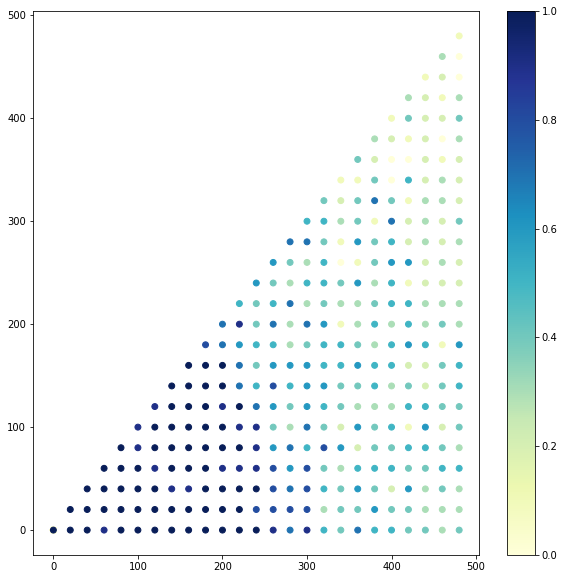

In [158]:
plot_scatter(position_x, position_y, avg_res)
plt.savefig('scatter_roundOff.png')
#plt.show()

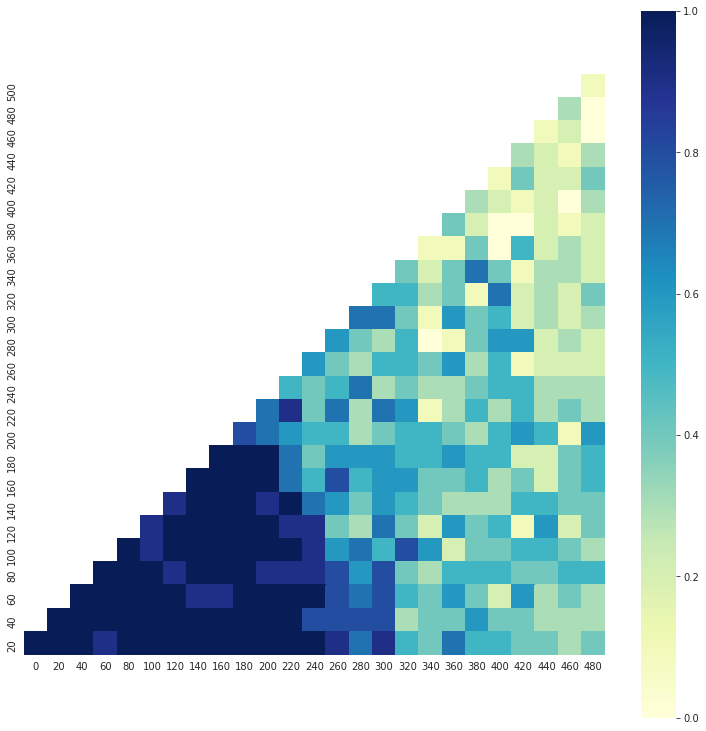

In [172]:
plot_hotmap(avg_res, mask)
#plt.savefig('hotmap_roundOff.png')

In [156]:
def plot_scatter(x, y, res):
    fig = plt.figure(figsize=(10,10))
    sc = plt.scatter(x.ravel(), y.ravel(), c=res.ravel(), marker='o', vmin=0, vmax=1, s=35, cmap='YlGnBu')
    plt.colorbar(sc)

In [171]:
def plot_hotmap(data, mask):
    with sns.axes_style("white"):
        fig = plt.figure(figsize=(13, 13))
        ax = sns.heatmap(data, mask=mask, vmax=1, square=True,  cmap="YlGnBu")
        ax.set_xticklabels(np.arange(0, 500, 20))
        ax.set_yticklabels(np.arange(500, 0, -20))

# generate periodic points in triangle area
corrdinate = np.arange(0, edge, scale)
x,y = np.meshgrid(corrdinate, corrdinate)
starting_point = np.array(list(zip(x.ravel(),y.ravel())))
triangle = starting_point[starting_point[:,0] >= starting_point[:,1]]

In [11]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
ro = round_off()
# setup optmizer
paras = {}
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro
paras['multi_runs'] = True
cma = cma_es()

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)

num = 300
points1 = sample_from_square([400,400], [200,200], num)
res1 = np.zeros((num, ))

for i in range(num):
    paras['mean0'] = points1[i,:].reshape(2,1)
    cma.set_parameters(paras)
    exp1.set_optimise(cma)
    status = exp1.do()
    if(status == 'global minimum'):
        res1[i] = 1
    else:
        res1[i] = 0

*******starting optimisation from intitial mean:  [324.56145052 179.10569794]
eigenvalue of variance = [0.13800392 0.26910853]
total iterations = 119, total evaluatios = 714
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [352.75952278 251.09826242]
eigenvalue of variance = [4.51318828 0.26006757]
total iterations = 97, total evaluatios = 582
found minimum position = [338. 255.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [353.34663613 266.02989882]
eigenvalue of variance = [0.42461152 0.56333357]
total iterations = 85, total evaluatios = 510
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [284.66803096 266.10866066]
eigenvalue of variance = [0.01246486 5.30254149]
total iterations = 99, total evaluatios = 594
found minimum position = [291. 278.], found 

eigenvalue of variance = [1.83300543 4.81739551]
total iterations = 25, total evaluatios = 150
found minimum position = [334.   3.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [283.01839798 220.90393948]
eigenvalue of variance = [6.19923214e-05 2.61913400e-01]
total iterations = 235, total evaluatios = 1410
found minimum position = [ 416. 1218.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [101.32381294  13.24730322]
eigenvalue of variance = [0.95438514 0.71625972]
total iterations = 35, total evaluatios = 210
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [336.00132617 187.01726508]
eigenvalue of variance = [4.11957597 0.35688591]
total iterations = 71, total evaluatios = 426
found minimum position = [338. 183.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisati

eigenvalue of variance = [1.89962989 0.40106556]
total iterations = 62, total evaluatios = 372
found minimum position = [249. 141.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [257.76869009 176.33693324]
eigenvalue of variance = [2.62845917 4.28659876]
total iterations = 17, total evaluatios = 102
found minimum position = [258. 176.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [374.75721078 182.32960792]
eigenvalue of variance = [5.24096438 1.59305825]
total iterations = 32, total evaluatios = 192
found minimum position = [372. 187.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [273.51842293 143.30004878]
eigenvalue of variance = [0.00102896 0.00679327]
total iterations = 400, total evaluatios = 2400
found minimum position = [-40223513. -56870731.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisa

eigenvalue of variance = [0.11823402 0.09178839]
total iterations = 93, total evaluatios = 558
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [227.92133475 209.17594999]
eigenvalue of variance = [0.05740208 0.04579587]
total iterations = 161, total evaluatios = 966
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [381.2032213  304.20977673]
eigenvalue of variance = [0.00259177 0.00255563]
total iterations = 297, total evaluatios = 1782
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [287.95315927 232.32160944]
eigenvalue of variance = [0.46669368 0.51800756]
total iterations = 73, total evaluatios = 438
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation 

eigenvalue of variance = [0.00123607 0.0026696 ]
total iterations = 400, total evaluatios = 2400
found minimum position = [22627. 73006.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [34.67424626 23.72768474]
eigenvalue of variance = [1.67861063 1.42400519]
total iterations = 27, total evaluatios = 162
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [398.01748022  38.34064924]
eigenvalue of variance = [0.12298418 0.17346576]
total iterations = 126, total evaluatios = 756
found minimum position = [-0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [184.6283699    5.05005534]
eigenvalue of variance = [1.17165488 0.96967129]
total iterations = 41, total evaluatios = 246
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisatio

eigenvalue of variance = [2.58097046e-05 2.17196502e-02]
total iterations = 400, total evaluatios = 2400
found minimum position = [2.251000e+03 8.361367e+06], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [320.61276241  68.33619734]
eigenvalue of variance = [7.74088715 0.6994745 ]
total iterations = 45, total evaluatios = 270
found minimum position = [308.  68.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [339.20262282 304.0480954 ]
eigenvalue of variance = [0.11916572 0.7126758 ]
total iterations = 158, total evaluatios = 948
found minimum position = [370. 307.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [358.49497814  62.73627767]
eigenvalue of variance = [0.49491315 0.35932016]
total iterations = 86, total evaluatios = 516
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******star

eigenvalue of variance = [0.39737333 0.78473035]
total iterations = 124, total evaluatios = 744
found minimum position = [378.  10.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [280.7287595  167.29322323]
eigenvalue of variance = [0.19439806 0.1333147 ]
total iterations = 118, total evaluatios = 708
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [299.69922854 217.68053893]
eigenvalue of variance = [0.68696118 0.74029598]
total iterations = 78, total evaluatios = 468
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [388.08107214  26.08883898]
eigenvalue of variance = [1.12910747 4.06906387]
total iterations = 37, total evaluatios = 222
found minimum position = [393.  23.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from 

eigenvalue of variance = [0.49274214 0.22463854]
total iterations = 137, total evaluatios = 822
found minimum position = [399. 394.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [102.33179419  51.93642225]
eigenvalue of variance = [1.53282057 1.179731  ]
total iterations = 36, total evaluatios = 216
found minimum position = [ 0. -0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [383.73666349  45.1414429 ]
eigenvalue of variance = [0.00269698 0.00167892]
total iterations = 269, total evaluatios = 1614
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [204.07716653  51.90152951]
eigenvalue of variance = [1.6567804  0.65604144]
total iterations = 44, total evaluatios = 264
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from

eigenvalue of variance = [0.88952831 0.60090832]
total iterations = 43, total evaluatios = 258
found minimum position = [0. 0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from intitial mean:  [397.40092997 178.72813388]
eigenvalue of variance = [0.00320849 1.0599795 ]
total iterations = 167, total evaluatios = 1002
found minimum position = [365. 126.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [274.90020071 149.02834267]
eigenvalue of variance = [0.65270277 2.77635192]
total iterations = 80, total evaluatios = 480
found minimum position = [270. 108.], found minimum = 20.0
dist_val 20.0
local minimum
*******starting optimisation from intitial mean:  [117.82981127 110.88804972]
eigenvalue of variance = [0.82567368 1.21223534]
total iterations = 37, total evaluatios = 222
found minimum position = [-0.  0.], found minimum = 4.440892098500626e-16
global minimum
*******starting optimisation from 

In [ ]:
pa2 = post_analysis_multi(points2, res2)
pa2.plot_cloud_point()

In [ ]:
pa2 = post_analysis_multi(points, res)
pa2.plot_prob_vs_radius()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
default = do_nothing()
# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = default

cma = cma_es()
cma.set_parameters(paras)

# boil down to one expreiment
exp1 = single_experiment()
exp1.set_objective(ak)
exp1.set_optimise(cma)
exp1.do()

In [ ]:
#exp1.analyser.print_mean_variance()

In [ ]:
np.random.seed(34)
# setup objective function
ak = ackley()
# setup adjust function optimizer
line = line_search(alpha=2, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = line

cma2 = cma_es()
cma2.set_parameters(paras)

# boil down to one expreiment
exp2 = single_experiment()
exp2.set_objective(ak)
exp2.set_optimise(cma2)
exp2.do()

In [ ]:
exp2.analyser.plot_distance()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
ro = round_off()

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = ro

cma3 = cma_es()
cma3.set_parameters(paras)

# boil down to one expreiment
exp3 = single_experiment()
exp3.set_objective(ak)
exp3.set_optimise(cma3)
exp3.do()

In [ ]:
np.random.seed(134)
# setup objective function
ak = ackley()
# setup adjust function optimizer
l1 = line_search_1step(alpha=1, beta=0.1)

# setup optmizer
paras = {}
paras['mean0'] = np.array([[629.193], [822.221]])
paras['std'] = np.ones((2,)) * 3
paras['tol'] = 1e-5
paras['adjust_func'] = l1

cma4 = cma_es()
cma4.set_parameters(paras)

# boil down to one expreiment
exp4 = single_experiment()
exp4.set_objective(ak)
exp4.set_optimise(cma4)
exp4.do()

In [ ]:
exp1.analyser.print_points_before_and_after_adjust()

In [ ]:
exp1.analyser.print_evaluations_per_iteration()

In [ ]:
exp1.analyser.print_mean_variance()

In [ ]:
exp1.analyser.plot_distance()

In [ ]:
ana = post_analysis(statistics, ak)

In [ ]:
ana.plot_distance()

In [ ]:
ana.animate_moving_cluster()

In [ ]:
ana.animate_scatterplot_distance()

In [ ]:
ana.plot_moving_cluster()